In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [17]:
data = pd.read_csv('data/peliculas_ETL.csv', low_memory=False, index_col='id')
df = data.copy()
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42196 entries, 862 to 461257
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  42196 non-null  object 
 1   budget                 42196 non-null  float64
 2   genres                 42196 non-null  object 
 3   original_language      42196 non-null  object 
 4   overview               42196 non-null  object 
 5   popularity             42196 non-null  float64
 6   production_companies   42196 non-null  object 
 7   production_countries   42196 non-null  object 
 8   release_date           42196 non-null  object 
 9   revenue                42196 non-null  float64
 10  runtime                42196 non-null  float64
 11  spoken_languages       42196 non-null  object 
 12  status                 42196 non-null  object 
 13  tagline                42196 non-null  object 
 14  title                  42196 non-null  object 
 15  vote

In [12]:
df.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count,release_year,return
count,4.219600e+04,42196.000000,4.219600e+04,42196.000000,42196.000000,42196.000000,42196.000000,4.219600e+04
mean,4.160088e+06,2.914097,1.116670e+07,93.853302,5.631261,109.391720,1991.914399,7.095609e+04
std,1.721499e+07,5.744661,6.377178e+07,37.578123,1.921395,489.341742,23.839319,7.745654e+06
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1874.000000,-1.000000e+02
25%,0.000000e+00,0.387424,0.000000e+00,85.000000,5.000000,3.000000,1978.000000,0.000000e+00
50%,0.000000e+00,1.136089,0.000000e+00,95.000000,6.000000,10.000000,2001.000000,0.000000e+00
75%,0.000000e+00,3.717885,0.000000e+00,106.000000,6.800000,35.000000,2010.000000,0.000000e+00
max,3.800000e+08,547.488300,2.787965e+09,1256.000000,10.000000,14075.000000,2020.000000,1.239638e+09


In [ ]:
df['overview'].values

In [14]:
df_nlp = df[['belongs_to_collection', 'genres',
       'overview',  'production_companies',
       'production_countries',
         'tagline', 'title',  'director', 'actors_names']].copy()

In [15]:
df_nlp

,belongs_to_collection,genres,overview,production_companies,production_countries,tagline,title,director,actors_names
id,,,,,,,,,
862,Toy Story Collection,"['Animation', 'Comedy', 'Family']","Led by Woody, Andy's toys live happily in his ...",['Pixar Animation Studios'],['United States of America'],N/D,Toy Story,John Lasseter,"['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim..."
8844,N/D,"['Adventure', 'Fantasy', 'Family']",When siblings Judy and Peter discover an encha...,"['TriStar Pictures', 'Teitler Film', 'Intersco...",['United States of America'],Roll the dice and unleash the excitement!,Jumanji,Joe Johnston,"['Robin Williams', 'Jonathan Hyde', 'Kirsten D..."
15602,Grumpy Old Men Collection,"['Romance', 'Comedy']",A family wedding reignites the ancient feud be...,"['Warner Bros.', 'Lancaster Gate']",['United States of America'],Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,Howard Deutch,"['Walter Matthau', 'Jack Lemmon', 'Ann-Margret..."
31357,N/D,"['Comedy', 'Drama', 'Romance']","Cheated on, mistreated and stepped on, the wom...",['Twentieth Century Fox Film Corporation'],['United States of America'],Friends are the people who let you be yourself...,Waiting to Exhale,Forest Whitaker,"['Whitney Houston', 'Angela Bassett', 'Loretta..."
11862,Father of the Bride Collection,['Comedy'],Just when George Banks has recovered from his ...,"['Sandollar Productions', 'Touchstone Pictures']",['United States of America'],Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,Charles Shyer,"['Steve Martin', 'Diane Keaton', 'Martin Short..."
...,...,...,...,...,...,...,...,...,...
289923,N/D,['Horror'],A film archivist revisits the story of Rustin ...,"['Neptune Salad Entertainment', 'Pirie Product...",['United States of America'],"Do you know what happened 50 years before ""The...",The Burkittsville 7,Ben Rock,"['Monty Bane', 'Lucy Butler', 'David Grammer',..."
222848,N/D,['Science Fiction'],It's the year 3000 AD. The world's most danger...,['Concorde-New Horizons'],['United States of America'],N/D,Caged Heat 3000,Aaron Osborne,"['Lisa Boyle', 'Kena Land', 'Zaneta Polard', '..."
111109,N/D,['Drama'],An artist struggles to finish his work while a...,['Sine Olivia'],['Philippines'],N/D,Century of Birthing,Lav Diaz,"['Angel Aquino', 'Perry Dizon', 'Hazel Orencio..."


In [27]:
df_EDA = df[['budget', 'revenue', 'runtime', 'vote_average',
       ]].copy()

In [28]:
df_EDA

,budget,revenue,runtime,vote_average
id,,,,
862,30000000.0,373554033.0,81.0,7.7
8844,65000000.0,262797249.0,104.0,6.9
15602,0.0,0.0,101.0,6.5
31357,16000000.0,81452156.0,127.0,6.1
11862,0.0,76578911.0,106.0,5.7
...,...,...,...,...
289923,0.0,0.0,30.0,7.0
222848,0.0,0.0,85.0,3.5
111109,0.0,0.0,360.0,9.0


In [29]:
df_EDA.describe()

,budget,revenue,runtime,vote_average
count,4.219600e+04,4.219600e+04,42196.000000,42196.000000
mean,4.160088e+06,1.116670e+07,93.853302,5.631261
std,1.721499e+07,6.377178e+07,37.578123,1.921395
min,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,85.000000,5.000000
50%,0.000000e+00,0.000000e+00,95.000000,6.000000
75%,0.000000e+00,0.000000e+00,106.000000,6.800000
max,3.800000e+08,2.787965e+09,1256.000000,10.000000


In [30]:
df_EDA2=df_EDA.drop(df_EDA[df_EDA["budget"] == 0].index)
df_EDA=df_EDA2.drop(df_EDA2[df_EDA2["revenue"] == 0].index)
df_EDA

,budget,revenue,runtime,vote_average
id,,,,
862,30000000.0,373554033.0,81.0,7.7
8844,65000000.0,262797249.0,104.0,6.9
31357,16000000.0,81452156.0,127.0,6.1
949,60000000.0,187436818.0,170.0,7.7
9091,35000000.0,64350171.0,106.0,5.5
...,...,...,...,...
395834,11000000.0,184770205.0,111.0,7.4
24049,12000000.0,19000000.0,185.0,6.9
280422,750000.0,3.0,0.0,6.0


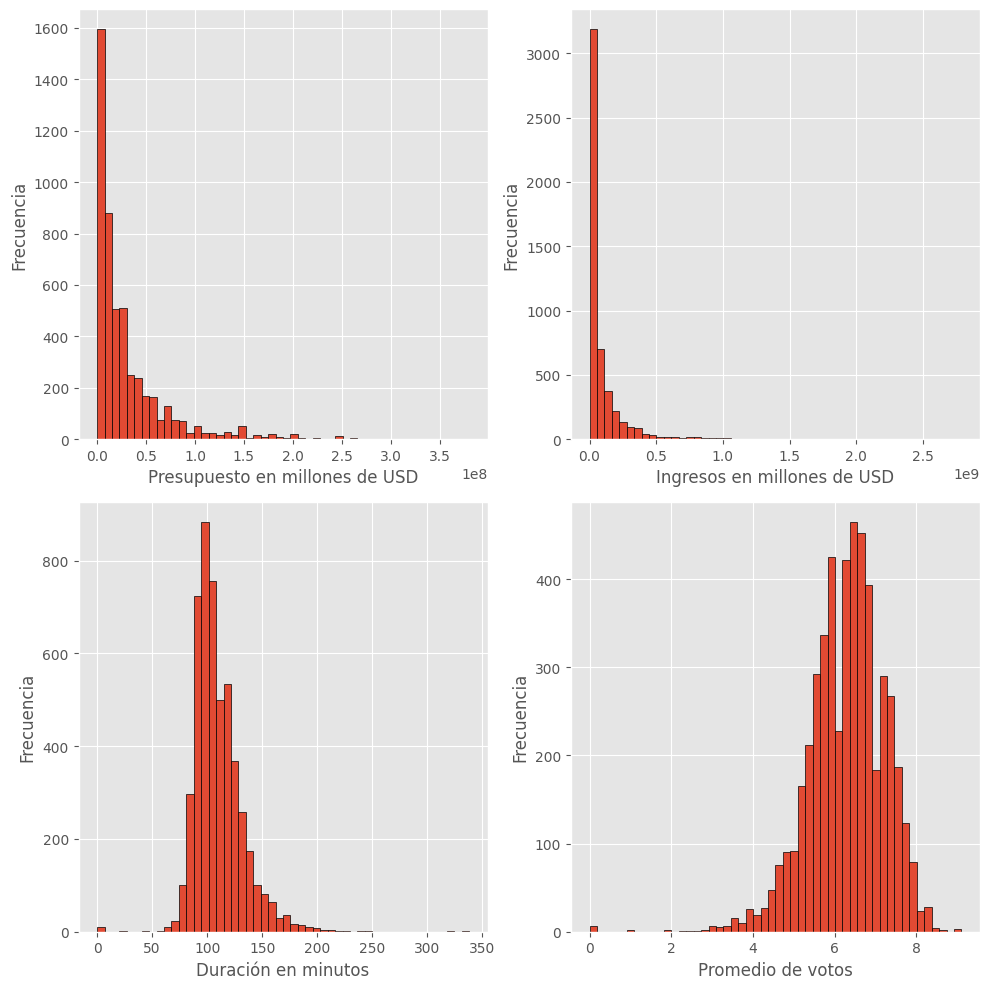

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Trazo el histograma para la variable budget
axs[0, 0].hist(df_EDA['budget'],edgecolor='black', bins=50)
axs[0, 0].set_xlabel('Presupuesto en millones de USD')
axs[0, 0].set_ylabel('Frecuencia')

# Trazo el histograma para la variable revenue
axs[0, 1].hist(df_EDA['revenue'], edgecolor='black', bins=50)
axs[0, 1].set_xlabel('Ingresos en millones de USD')
axs[0, 1].set_ylabel('Frecuencia')

# Trazo el histograma para la variable runtime
axs[1, 0].hist(df_EDA['runtime'], edgecolor='black', bins=50)
axs[1, 0].set_xlabel('Duración en minutos')
axs[1, 0].set_ylabel('Frecuencia')

# Trazo el histograma para la variable vote_average
axs[1, 1].hist(df_EDA['vote_average'], edgecolor='black', bins=50)
axs[1, 1].set_xlabel('Promedio de votos')
axs[1, 1].set_ylabel('Frecuencia')

# Ajusto los espacios entre subplots y mostrar la figura
plt.tight_layout()
plt.show()